In [1]:
import h5py
import numpy as np

datasets = h5py.File('/home/sunji/ANN/glove_200_angular/glove-200-angular.hdf5', 'r')

In [3]:
mini = 100.0
maxi = 0.0
for p in datasets['train']:
    for pp in p:
        if pp > maxi:
            maxi = pp
        if pp < mini:
            mini = pp

In [4]:
print (maxi, mini)

218.0 0.0


In [2]:
datasets['train'][0]

array([-0.2301   ,  0.07255  ,  0.24698  , -0.36867  ,  0.38849  ,
       -0.35696  , -0.424    , -0.2106   ,  0.14974  , -0.36732  ,
        0.37257  ,  0.35924  , -0.018775 , -0.25047  ,  0.68308  ,
       -0.1796   ,  0.12527  , -0.24172  , -0.14929  ,  0.63569  ,
        0.67974  ,  0.28577  , -0.10336  ,  0.2668   ,  0.31282  ,
        0.63371  , -0.38518  ,  0.1466   , -0.34958  , -0.2967   ,
        0.085846 ,  0.76451  ,  0.59882  , -0.023301 , -0.39828  ,
       -0.51941  ,  0.15152  ,  0.18698  ,  0.21637  ,  0.17061  ,
        0.58075  , -0.029163 , -0.15885  ,  0.086282 , -0.0092299,
        0.46781  ,  0.040814 ,  0.09262  ,  0.32869  , -0.22015  ,
       -0.33748  , -0.020889 ,  0.072092 ,  0.070397 ,  0.0056692,
        0.23296  ,  0.053131 ,  0.017756 ,  0.42696  , -0.37082  ,
        0.39706  ,  0.64921  ,  0.61824  ,  0.061149 , -0.064628 ,
        0.2898   ,  0.50897  ,  0.029401 ,  0.1483   ,  0.23182  ,
        0.0011585,  0.30957  ,  0.065942 , -0.084695 , -0.0565

In [9]:
euclidean_dist_normalized(datasets['train'][5] / 218.0, datasets['train'][100] / 218.0)

0.17830265

## k-means

In [2]:
def euclidean_dist_normalized(x1, x2=None, eps=1e-8):
    return np.sqrt(((x1 - x2) ** 2).mean())

In [3]:
from scipy import spatial

from multiprocessing import Pool

def angular_dist(x1, x2=None, eps=1e-8):
    cosine_sim = 1 - spatial.distance.cosine(x1, x2)
    distance = np.arccos(cosine_sim) / 3.14159267
    return distance

angular_dist(datasets['train'][0], datasets['train'][100])

0.404985964625046

In [4]:
from sklearn.decomposition import PCA
from sklearn import manifold

X = np.array(datasets['train'])
pca = PCA(n_components=3)
new_X = pca.fit_transform(X)

In [5]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

kmeans = MiniBatchKMeans(n_clusters=100,random_state=0,batch_size=100).fit(new_X)

In [6]:
clusters = kmeans.predict(new_X)

In [7]:
clusters_points = []
for cluster_id in range(100):
    clusters_points.append(np.array(datasets['train'])[(clusters == cluster_id).nonzero()])

In [8]:
for cc in clusters_points:
    print (len(cc))

21002
7585
20072
20501
9835
7053
4612
8862
6927
15750
12257
4633
23344
7865
17241
8881
7432
21209
4285
4884
5573
12063
8629
9347
13000
18926
11938
2008
9458
20117
5167
24637
16506
4974
9768
24978
11416
10900
9872
4392
8858
17615
5080
12512
6673
6482
10698
6538
15843
10325
6219
26745
28277
23462
10349
9829
1290
7895
5464
5025
15746
10512
15796
2160
1720
13290
19456
7105
8093
20274
7049
13444
4270
14803
13106
7345
18853
7240
13331
10130
6414
17541
5768
11370
9801
1750
9711
17169
12820
15282
25213
11949
22146
26562
5596
13140
4932
12521
24137
12891


## collect query ground truth

In [9]:
import torch.nn.functional as F

import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy import spatial

from multiprocessing import Pool

def angular_dist(x1, x2=None, eps=1e-8):
    cosine_sim = 1 - spatial.distance.cosine(x1, x2)
    distance = np.arccos(cosine_sim) / 3.14159267
    return distance

def euclidean_dist_normalized(x1, x2=None, eps=1e-8):
    return np.sqrt(((x1 - x2) ** 2).mean())

queries = np.array(datasets['test'])

def run_proc(clus):
    dataset = clusters_points[clus]
    ground_truth = []
    slot = 0.002
    for idxx, q in enumerate(queries):
        if idxx % 100 == 0:
            print (clus, idxx)
        thresholds = np.arange(0.4, 0.5, slot)
        count = [0 for _ in thresholds]
        for d in dataset:
            distance = angular_dist(q, d)
#             print (distance)
            for idx, threshold in enumerate(thresholds):
                if distance < threshold + slot and distance >= threshold:
                    count[idx] += 1
        for idx, threshold in enumerate(thresholds):
#             print (threshold, threshold + slot, count[idx])
            ground_truth.append((clus, idxx, threshold, threshold + slot, count[idx]))
    return ground_truth
#             print (threshold, threshold + slot, count[idx])
ground_truth_total = []
processes = []
pool = Pool(processes=30)
for clus in range(100):
    processes.append(pool.apply_async(run_proc, args=(clus,)))
pool.close()
pool.join()

for i in processes:
    ground_truth_total.append(i.get())

0 0
1 0
5 0
18 0
2 0
4 0
16 0
6 0
17 0
20 0
21 0
7 0
23 0
19 0
22 0
12 0
3 0
13 0
29 0
25 0
24 0
27 0
26 0
14 0
28 0
15 0
10 0
11 0
8 0
9 0
27 100
27 200
19 100
18 100
20 100
6 100
11 100
27 300
5 100
8 100
22 100
16 100
27 400
28 100
1 100
13 100
19 200
18 200
4 100
7 100
15 100
20 200
23 100
27 500
6 200
11 200
26 100
24 100
27 600
21 100
19 300
10 100
5 200
18 300
27 700
8 200
20 300
6 300
11 300
16 200
22 200
27 800
1 200
13 200
28 200
9 100
25 100
19 400
29 100
18 400
27 900
14 100
4 200
15 200
7 200
20 400
6 400
5 300
23 200
11 400
27 1000
26 200
19 500
2 100
27 1100
8 300
17 100
3 100
18 500
0 100
24 200
16 300
22 300
27 1200
6 500
20 500
1 300
12 100
11 500
13 300
28 300
21 200
19 600
27 1300
5 400
10 200
18 600
4 300
15 300
27 1400
7 300
6 600
20 600
23 300
8 400
11 600
27 1500
19 700
22 400
16 400
18 700
26 300
27 1600
1 400
5 500
6 700
13 400
9 200
28 400
27 1700
19 800
24 300
25 200
20 700
11 700
29 200
18 800
27 1800
4 400
14 200
8 500
7 400
6 800
15 400
21 300
27 1900
16 

28 3600
8 4100
29 1700
23 3100
6 7200
7 3300
18 7000
11 6400
20 5600
3 1400
1 3800
19 7100
5 4800
4 3400
30 2100
15 3300
6 7300
14 1700
16 4000
26 2900
18 7100
22 4000
10 2400
11 6500
13 3800
25 1800
8 4200
20 5700
19 7200
28 3700
24 2700
6 7400
30 2200
17 1400
18 7200
5 4900
7 3400
23 3200
11 6600
1 3900
21 2500
19 7300
4 3500
6 7500
16 4100
20 5800
15 3400
22 4100
30 2300
18 7300
8 4300
0 1400
13 3900
11 6700
26 3000
9 1900
19 7400
5 5000
28 3800
6 7600
29 1800
20 5900
18 7400
12 1300
10 2500
7 3500
30 2400
1 4000
23 3300
24 2800
19 7500
11 6800
22 4200
16 4200
6 7700
2 1500
4 3600
8 4400
15 3500
5 5100
14 1800
18 7500
13 4000
3 1500
21 2600
20 6000
25 1900
30 2500
28 3900
19 7600
6 7800
11 6900
26 3100
1 4100
18 7600
7 3600
16 4300
22 4300
19 7700
23 3400
8 4500
5 5200
6 7900
30 2600
20 6100
11 7000
4 3700
13 4100
17 1500
10 2600
24 2900
15 3600
18 7700
9 2000
28 4000
19 7800
6 8000
11 7100
30 2700
1 4200
20 6200
5 5300
29 1900
16 4400
18 7800
8 4600
22 4400
0 1500
21 2700
7 3700
26

13 8100
1 8200
30 8400
24 5700
16 8600
8 9000
4 7300
33 3800
26 6200
29 3700
23 6800
36 200
7 7300
22 8600
15 7200
28 7900
30 8500
32 1400
12 2700
9 4000
13 8200
1 8300
33 3900
34 1600
8 9100
16 8700
21 5300
17 3000
10 5200
2 3100
4 7400
24 5800
30 8600
22 8700
26 6300
23 6900
28 8000
25 3900
33 4000
14 3700
15 7300
7 7400
1 8400
13 8300
36 300
8 9200
16 8800
35 400
3 3100
30 8700
31 1000
4 7500
34 1700
33 4100
29 3800
22 8800
21 5400
10 5300
0 3000
28 8100
24 5900
32 1500
8 9300
23 7000
13 8400
16 8900
15 7400
7 7500
1 8500
26 6400
30 8800
9 4100
33 4200
36 400
4 7600
22 8900
30 8900
8 9400
28 8200
12 2800
16 9000
1 8600
25 4000
2 3200
17 3100
34 1800
33 4300
13 8500
14 3800
23 7100
7 7600
15 7500
21 5500
26 6500
24 6000
10 5400
30 9000
22 9000
4 7700
8 9500
33 4400
29 3900
1 8700
16 9100
3 3200
28 8300
36 500
32 1600
13 8600
9 4200
30 9100
15 7600
23 7200
7 7700
34 1900
33 4500
31 1100
22 9100
0 3100
8 9600
26 6600
35 500
24 6100
21 5600
4 7800
1 8800
16 9200
10 5500
28 8400
30 9200


12 4400
31 2600
9 6600
36 3800
40 3000
3 5000
10 8500
39 6400
29 6100
49 200
2 5100
44 2300
45 2200
21 8900
42 4500
34 5300
38 3400
35 1800
47 1500
0 4800
17 4900
14 6100
39 6500
46 1300
37 2700
32 4000
24 9500
39 6600
43 1700
42 4600
40 3100
36 3900
48 500
45 2300
44 2400
47 1600
10 8600
25 6400
39 6700
9 6700
49 300
38 3500
34 5400
42 4700
21 9000
41 1400
39 6800
46 1400
29 6200
45 2400
44 2500
37 2800
47 1700
24 9600
40 3200
42 4800
3 5100
39 6900
36 4000
14 6200
2 5200
12 4500
31 2700
38 3600
43 1800
34 5500
32 4100
10 8700
42 4900
39 7000
49 400
45 2500
17 5000
0 4900
44 2600
47 1800
21 9100
25 6500
48 600
9 6800
39 7100
46 1500
40 3300
42 5000
24 9700
37 2900
36 4100
38 3700
34 5600
45 2600
35 1900
39 7200
29 6300
47 1900
44 2700
42 5100
10 8800
49 500
41 1500
43 1900
39 7300
14 6300
21 9200
32 4200
3 5200
40 3400
42 5200
45 2700
24 9800
2 5300
38 3800
46 1600
47 2000
39 7400
44 2800
34 5700
36 4200
25 6600
9 6900
37 3000
42 5300
12 4600
39 7500
48 700
31 2800
17 5100
0 5000
45 2

50 5500
0 6800
9 9400
52 900
44 8300
51 1000
17 7000
46 4900
47 7600
25 9100
40 7700
37 6400
32 6800
38 8100
12 6300
50 5600
36 7800
45 8400
48 2900
14 8700
43 4800
54 1200
55 0
3 7200
49 4000
44 8400
47 7700
2 7400
29 8800
41 3500
50 5700
46 5000
45 8500
40 7800
53 1000
38 8200
37 6500
44 8500
9 9500
31 4500
36 7900
55 100
47 7800
50 5800
25 9200
54 1300
43 4900
32 6900
49 4100
45 8600
0 6900
35 3400
44 8600
17 7100
46 5100
38 8300
40 7900
48 3000
14 8800
50 5900
47 7900
37 6600
55 200
3 7300
36 8000
29 8900
45 8700
12 6400
50 6000
54 1400
44 8700
2 7500
47 8000
9 9600
49 4200
41 3600
43 5000
52 1000
38 8400
51 1100
40 8000
46 5200
25 9300
45 8800
32 7000
50 6100
37 6700
47 8100
44 8800
55 300
36 8100
31 4600
14 8900
53 1100
50 6200
48 3100
38 8500
45 8900
54 1500
0 7000
49 4300
17 7200
40 8100
29 9000
46 5300
43 5100
44 8900
47 8200
37 6800
9 9700
50 6300
3 7400
55 400
45 9000
36 8200
25 9400
32 7100
35 3500
38 8600
12 6500
2 7600
41 3700
44 9000
47 8300
50 6400
40 8200
54 1600
49 44

64 8200
60 1100
49 7500
63 6600
59 4700
64 8300
17 8800
63 6700
64 8400
58 4300
67 1000
64 8500
63 6800
46 8200
48 5000
37 9900
59 4800
64 8600
57 2800
12 7900
55 3300
63 6900
31 6000
43 7700
32 9200
2 9200
3 9000
64 8700
54 4300
58 4400
63 7000
61 1700
64 8800
64 8900
59 4900
63 7100
49 7600
67 1100
64 9000
63 7200
65 1000
64 9100
62 1000
58 4500
63 7300
57 2900
64 9200
59 5000
66 600
63 7400
64 9300
68 0
46 8300
55 3400
60 1200
41 5400
52 2100
35 4700
64 9400
63 7500
0 8600
67 1200
54 4400
58 4600
61 1800
59 5100
64 9500
43 7800
63 7600
48 5100
49 7700
64 9600
32 9300
63 7700
53 2400
64 9700
17 8900
57 3000
68 100
63 7800
59 5200
64 9800
58 4700
51 2300
64 9900
67 1300
63 7900
2 9300
69 0
55 3500
65 1100
3 9100
63 8000
46 8400
12 8000
59 5300
58 4800
31 6100
63 8100
62 1100
54 4500
61 1900
68 200
49 7800
57 3100
43 7900
63 8200
59 5400
67 1400
60 1300
63 8300
58 4900
48 5200
41 5500
63 8400
32 9400
66 700
59 5500
63 8500
68 300
55 3600
58 5000
46 8500
0 8700
63 8600
35 4800
57 3200
6

68 4700
66 2400
72 6100
57 7900
79 900
12 9700
53 3900
70 4700
61 5400
60 3500
72 6200
54 8300
67 6700
77 2000
75 2200
65 3700
80 1400
55 7500
74 1400
71 2000
68 4800
72 6300
78 800
62 3400
70 4800
57 8000
69 1800
67 6800
72 6400
77 2100
79 1000
80 1500
75 2300
61 5500
31 7800
73 1300
68 4900
54 8400
48 7700
70 4900
41 7600
72 6500
35 6500
52 3400
55 7600
57 8100
67 6900
76 900
77 2200
80 1600
65 3800
72 6600
60 3600
74 1500
75 2400
66 2500
71 2100
70 5000
61 5600
78 900
68 5000
79 1100
51 3700
67 7000
72 6700
12 9800
54 8500
57 8200
62 3500
80 1700
55 7700
77 2300
72 6800
53 4000
70 5100
75 2500
67 7100
68 5100
73 1400
61 5700
48 7800
72 6900
69 1900
79 1200
57 8300
80 1800
77 2400
70 5200
74 1600
65 3900
41 7700
78 1000
54 8600
72 7000
71 2200
67 7200
75 2600
31 7900
60 3700
55 7800
68 5200
35 6600
76 1000
72 7100
61 5800
80 1900
70 5300
77 2500
57 8400
62 3600
67 7300
66 2600
72 7200
79 1300
75 2700
68 5300
73 1500
12 9900
54 8700
70 5400
72 7300
52 3500
55 7900
80 2000
48 7900
78 1

85 9100
52 4600
86 1100
48 9900
80 7300
60 5900
85 9200
82 4200
61 9200
85 9300
41 9500
77 7500
51 5000
74 4100
73 3600
85 9400
66 4200
65 6600
85 9500
68 9500
53 5500
80 7400
75 7600
82 4300
84 1900
85 9600
79 4600
78 3500
85 9700
85 9800
35 8200
81 1700
83 1800
77 7600
86 1200
62 5900
85 9900
71 4700
61 9300
82 4400
80 7500
69 3600
75 7700
87 200
88 0
68 9600
60 6000
76 2800
79 4700
31 9500
65 6700
82 4500
84 2000
74 4200
77 7700
89 0
80 7600
73 3700
86 1300
75 7800
78 3600
82 4600
41 9600
83 1900
61 9400
68 9700
80 7700
77 7800
71 4800
88 100
66 4300
79 4800
62 6000
84 2100
82 4700
52 4700
60 6100
65 6800
75 7900
81 1800
53 5600
51 5100
80 7800
74 4300
86 1400
68 9800
35 8300
87 300
77 7900
82 4800
89 100
61 9500
79 4900
69 3700
83 2000
76 2900
73 3800
80 7900
78 3700
75 8000
71 4900
82 4900
84 2200
88 200
31 9600
77 8000
68 9900
65 6900
62 6100
86 1500
80 8000
41 9700
60 6200
82 5000
79 5000
75 8100
61 9600
74 4400
66 4400
83 2100
77 8100
80 8100
82 5100
81 1900
84 2300
71 5000
89 

79 9400
69 5800
87 2600
94 5200
86 5600
78 6900
52 6200
71 8300
84 6500
65 9900
96 5800
89 2700
83 5600
74 7800
62 8800
94 5300
90 1500
96 5900
95 2000
81 4100
51 6700
79 9500
86 5700
91 3000
76 5100
66 6600
84 6600
94 5400
96 6000
88 3400
83 5700
78 7000
73 6700
97 1200
60 9000
96 6100
71 8400
99 0
94 5500
74 7900
92 1500
86 5800
84 6700
69 5900
87 2700
89 2800
79 9600
96 6200
62 8900
95 2100
94 5600
91 3100
83 5800
93 1200
96 6300
53 7500
98 300
88 3500
78 7100
81 4200
86 5900
94 5700
84 6800
76 5200
73 6800
96 6400
97 1300
66 6700
52 6300
79 9700
71 8500
99 100
60 9100
74 8000
94 5800
96 6500
83 5900
90 1600
95 2200
91 3200
86 6000
89 2900
51 6800
62 9000
84 6900
96 6600
87 2800
94 5900
78 7200
88 3600
69 6000
79 9800
96 6700
92 1600
97 1400
94 6000
73 6900
86 6100
83 6000
71 8600
99 200
84 7000
96 6800
74 8100
81 4300
76 5300
66 6800
91 3300
60 9200
94 6100
95 2300
53 7600
79 9900
96 6900
98 400
88 3700
62 9100
89 3000
78 7300
86 6200
93 1300
94 6200
84 7100
96 7000
83 6100
87 2900

92 4300
99 5000
91 8900
97 6300
51 9200
89 7200
88 9000
95 7200
90 4100
93 3600
99 5100
91 9000
52 8700
87 6600
76 8900
97 6400
81 8200
98 3000
69 9400
88 9100
89 7300
92 4400
95 7300
91 9100
99 5200
97 6500
51 9300
87 6700
76 9000
81 8300
88 9200
90 4200
95 7400
93 3700
91 9200
89 7400
69 9500
99 5300
97 6600
98 3100
92 4500
52 8800
88 9300
87 6800
95 7500
91 9300
81 8400
99 5400
97 6700
76 9100
89 7500
51 9400
69 9600
88 9400
90 4300
91 9400
95 7600
93 3800
99 5500
97 6800
98 3200
87 6900
92 4600
89 7600
81 8500
88 9500
76 9200
91 9500
95 7700
52 8900
99 5600
97 6900
69 9700
87 7000
51 9500
89 7700
88 9600
91 9600
81 8600
90 4400
95 7800
92 4700
98 3300
99 5700
97 7000
93 3900
76 9300
91 9700
88 9700
89 7800
69 9800
87 7100
95 7900
97 7100
99 5800
81 8700
52 9000
91 9800
51 9600
88 9800
92 4800
90 4500
98 3400
89 7900
95 8000
76 9400
97 7200
99 5900
87 7200
93 4000
69 9900
91 9900
81 8800
88 9900
95 8100
97 7300
99 6000
89 8000
52 9100
92 4900
76 9500
87 7300
51 9700
90 4600
81 8900


In [9]:
len(ground_truth_total)

100

In [10]:
ground_truth_total[0]

[(0, 0, 0.0, 0.004, 0),
 (0, 0, 0.004, 0.008, 0),
 (0, 0, 0.008, 0.012, 0),
 (0, 0, 0.012, 0.016, 0),
 (0, 0, 0.016, 0.02, 0),
 (0, 0, 0.02, 0.024, 0),
 (0, 0, 0.024, 0.028, 0),
 (0, 0, 0.028, 0.032, 0),
 (0, 0, 0.032, 0.036000000000000004, 0),
 (0, 0, 0.036000000000000004, 0.04000000000000001, 0),
 (0, 0, 0.04, 0.044, 0),
 (0, 0, 0.044, 0.048, 0),
 (0, 0, 0.048, 0.052000000000000005, 0),
 (0, 0, 0.052000000000000005, 0.05600000000000001, 0),
 (0, 0, 0.056, 0.06, 0),
 (0, 0, 0.06, 0.064, 0),
 (0, 0, 0.064, 0.068, 0),
 (0, 0, 0.068, 0.07200000000000001, 0),
 (0, 0, 0.07200000000000001, 0.07600000000000001, 0),
 (0, 0, 0.076, 0.08, 0),
 (0, 0, 0.08, 0.084, 0),
 (0, 0, 0.084, 0.08800000000000001, 0),
 (0, 0, 0.088, 0.092, 0),
 (0, 0, 0.092, 0.096, 0),
 (0, 0, 0.096, 0.1, 0),
 (0, 0, 0.1, 0.10400000000000001, 0),
 (0, 0, 0.10400000000000001, 0.10800000000000001, 0),
 (0, 0, 0.108, 0.112, 0),
 (0, 0, 0.112, 0.116, 0),
 (0, 0, 0.116, 0.12000000000000001, 0),
 (0, 0, 0.12, 0.124, 0),
 (0, 0, 

In [1]:
import pickle

with open('/home/sunji/ANN/sift_128_euclidean/ground_truth_sift_128_euclidean_0_0_0_5.pkl', 'rb') as f:
    ground_truth_total = pickle.load(f)

In [10]:
import pickle

with open('/home/sunji/ANN/glove_200_angular/ground_truth_glove_200_angular_0_4_0_5.pkl', 'wb') as f:
    pickle.dump(ground_truth_total, f)

In [11]:
import pickle

with open('/home/sunji/ANN/glove_200_angular/clusters_glove_200_angular.pkl', 'wb') as f:
    pickle.dump(clusters_points, f)

## Trash Bin

In [190]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Linear(dimension, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
#         self.embedding2 = nn.Linear(128, 128)
#         self.bn2 = nn.BatchNorm1d(num_features=128)
        self.embedding3 = nn.Linear(128, len_hash_code)

    def forward(self, point):
        # batch * 100 * 25
        # batch * 16
        point1 = F.relu(self.bn1(self.embedding(point)))
#         point2 = F.relu(self.bn2(self.embedding2(point1)))
        point3 = self.embedding3(point1)
        # batch * 100
        return point3

def approximate_hamming_distance(left_embedding, right_embedding):
    return ((left_embedding - right_embedding) ** 2).sum(dim=1)

def euclidean_distance(lefts, rights):
    return ((lefts - rights) ** 2).sum(dim=1)

def l1_distance(lefts, rights):
    return ((lefts - rights) ** 2).sum(dim=1)

def angular_distance(x1, x2=None, eps=1e-8):
    cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8)
    distance = torch.acos(cosine_sim) / 3.14159267
    return distance 

def diff_loss(hash_distance, input_distance):
#     print (hash_distance[0])
    input_distance = torch.floor(input_distance * 40)
    return F.mse_loss(input_distance, hash_distance)

def hash_loss(hash_distance, input_distance):
#     return F.mse_loss(hash_distance, input_distance)
#     return (-(hash_distance * input_distance) + 0.02 * (hash_distance.max()) ** 2).mean()
#     print ('new1')
#     print (hash_distance)
#     return - (input_distance * hash_distance + 0.5 * hash_distance).sum() / ((1.0 - input_distance) * hash_distance).sum()
    return ((1.0 - input_distance) ** 2 * hash_distance).sum() - (5 * torch.log(hash_distance + 1.0)).sum()

def triple_loss(embedding_distance, origin_distance):
    loss = 0.0
    loss1 = (embedding_distance[0] - embedding_distance[1]) * ((origin_distance[0] - origin_distance[1]) / torch.abs(origin_distance[0] - origin_distance[1]))
    loss1 = loss1 * (loss1 > 0).type(torch.FloatTensor)
    loss2 = (embedding_distance[1] - embedding_distance[2]) * ((origin_distance[1] - origin_distance[2]) / torch.abs(origin_distance[1] - origin_distance[2]))
    loss2 = loss2 * (loss2 > 0).type(torch.FloatTensor)
    loss3 = (embedding_distance[2] - embedding_distance[0]) * ((origin_distance[2] - origin_distance[0]) / torch.abs(origin_distance[2] - origin_distance[0]))
    loss3 = loss3 * (loss3 > 0).type(torch.FloatTensor)
#     print (embedding_distance[0].size())
#     print (emb.size())
#     print (torch.max(emb, dim=1)[0].size())
    return (loss1 + loss2 + loss3).mean()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print(len(train_loader))
#     for round in range(epoch):
        
    for batch_idx, (triple1, triple2, triple3) in enumerate(train_loader):
        triple1, triple2, triple3 = triple1.to(device), triple2.to(device), triple3.to(device)
        optimizer.zero_grad()
        triple1_embedding = model(triple1)
        triple2_embedding = model(triple2)
        triple3_embedding = model(triple3)
#         print ('left_embedding: ', left_embedding.size())
#         print ('right_embedding: ', right_embedding.size())
        embedding_distance_1 = l1_distance(triple1_embedding, triple2_embedding)
        embedding_distance_2 = l1_distance(triple2_embedding, triple3_embedding)
        embedding_distance_3 = l1_distance(triple3_embedding, triple1_embedding)
        origin_distance_1 = angular_distance(triple1, triple2)
        origin_distance_2 = angular_distance(triple2, triple3)
        origin_distance_3 = angular_distance(triple3, triple1)
        
        loss = diff_loss(embedding_distance_1, origin_distance_1)
#         loss = triple_loss((embedding_distance_1, embedding_distance_2, embedding_distance_3),
#                            (origin_distance_1, origin_distance_2, origin_distance_3))
        
#         print ('input_distance: ', input_distance)
#         print ('input_distance: ', input_distance.size())
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 5.0)
        optimizer.step()
#         print ('parameters: ', model.state_dict())
#         print ('gradient', )
        
        if batch_idx % batch_log_interval == 0:
#             for xx in zip(hash_distance, input_distance):
#                 print (xx[0], xx[1])
            print('Train Epoch: {}\tLoss: {}'.format(
                epoch, loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    hash_distances = []
    input_distances = []
    with torch.no_grad():
        for triple1, triple2, triple3 in test_loader:
            triple1, triple2, triple3 = triple1.to(device), triple2.to(device), triple3.to(device)
            triple1_embedding = model(triple1)
            triple2_embedding = model(triple2)
            triple3_embedding = model(triple3)
    #         print ('left_embedding: ', left_embedding.size())
    #         print ('right_embedding: ', right_embedding.size())
            embedding_distance_1 = l1_distance(triple1_embedding, triple2_embedding)
            embedding_distance_2 = l1_distance(triple2_embedding, triple3_embedding)
            embedding_distance_3 = l1_distance(triple3_embedding, triple1_embedding)
            origin_distance_1 = angular_distance(triple1, triple2)
            origin_distance_2 = angular_distance(triple2, triple3)
            origin_distance_3 = angular_distance(triple3, triple1)
            loss = diff_loss(embedding_distance_1, origin_distance_1)
#             loss = triple_loss((embedding_distance_1, embedding_distance_2, embedding_distance_3),
#                                (origin_distance_1, origin_distance_2, origin_distance_3))
    #         print ('input_distance: ', input_distance)
    #         print ('input_distance: ', input_distance.size())
            test_loss += loss.item() # sum up batch loss
    

    test_loss /= len(test_loader)

    print('Test set: Average loss: {:.4f}\n'.format(
        test_loss))
    
    return hash_distances, input_distances

    
def prepare_dataset(training_data, train_num, test_num):
    print (training_data.shape)
    number = train_num % training_data.shape[0]
    train_triple1 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    train_triple2 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    train_triple3 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    number = train_num - train_num % training_data.shape[0]
    while number > training_data.shape[0]:
        train_triple1 = np.concatenate((train_triple1, training_data))
        train_triple2 = np.concatenate((train_triple2, training_data))
        train_triple3 = np.concatenate((train_triple3, training_data))
        np.random.shuffle(train_triple1)
        np.random.shuffle(train_triple2)
        np.random.shuffle(train_triple3)
        number -= training_data.shape[0]
    train_triple1 = np.concatenate((train_triple1, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    train_triple2 = np.concatenate((train_triple2, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    train_triple3 = np.concatenate((train_triple3, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    np.random.shuffle(train_triple1)
    np.random.shuffle(train_triple2)
    np.random.shuffle(train_triple3)
    
    test_triple1 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    test_triple2 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    test_triple3 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    np.random.shuffle(test_triple1)
    np.random.shuffle(test_triple2)
    np.random.shuffle(test_triple3)
    
    return (torch.FloatTensor(train_triple1), torch.FloatTensor(train_triple2), torch.FloatTensor(train_triple3),
            torch.FloatTensor(test_triple1), torch.FloatTensor(test_triple2), torch.FloatTensor(test_triple3))
        

def run():
    # Training settings
#     parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#     parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                         help='input batch size for training (default: 64)')
#     parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                         help='input batch size for testing (default: 1000)')
#     parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                         help='number of epochs to train (default: 10)')
#     parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                         help='learning rate (default: 0.01)')
#     parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                         help='SGD momentum (default: 0.5)')
#     parser.add_argument('--no-cuda', action='store_true', default=False,
#                         help='disables CUDA training')
#     parser.add_argument('--seed', type=int, default=1, metavar='S',
#                         help='random seed (default: 1)')
#     parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                         help='how many batches to wait before logging training status')
    
#     parser.add_argument('--save-model', action='store_true', default=False,
#                         help='For Saving the current Model')
#     args = parser.parse_args()
    use_cuda = torch.cuda.is_available()

#     torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    train_dataset = np.array(f['train'])
    train_triple1, train_triple2, train_triple3,test_triple1,test_triple2,test_triple3 = prepare_dataset(train_dataset, train_num, test_num)
    
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_triple1, train_triple2, train_triple3), batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_triple1,test_triple2,test_triple3), batch_size=batch_size, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
        
    return model

dimension = 200
len_hash_code = 20
batch_log_interval = 100
batch_size = 1024
train_num = 2000000
test_num = 10000
learning_rate = 0.001
save_model = False
epochs = 20

model = run()

(1183514, 200)
1954
Train Epoch: 1	Loss: 287.8174133300781
Train Epoch: 1	Loss: 41.85979461669922
Train Epoch: 1	Loss: 36.91990280151367
Train Epoch: 1	Loss: 30.303878784179688
Train Epoch: 1	Loss: 28.23041534423828
Train Epoch: 1	Loss: 30.316242218017578
Train Epoch: 1	Loss: 28.25247573852539
Train Epoch: 1	Loss: 29.15850067138672
Train Epoch: 1	Loss: 25.41613006591797
Train Epoch: 1	Loss: 23.38016128540039
Train Epoch: 1	Loss: 23.78240394592285
Train Epoch: 1	Loss: 23.99214744567871
Train Epoch: 1	Loss: 23.212833404541016
Train Epoch: 1	Loss: 21.11407470703125
Train Epoch: 1	Loss: 24.2458553314209
Train Epoch: 1	Loss: 21.179821014404297
Train Epoch: 1	Loss: 22.41728401184082
Train Epoch: 1	Loss: 22.16063690185547
Train Epoch: 1	Loss: 20.664649963378906
Train Epoch: 1	Loss: 21.061704635620117
Test set: Average loss: 21.5539

1954
Train Epoch: 2	Loss: 20.587650299072266
Train Epoch: 2	Loss: 20.98163604736328
Train Epoch: 2	Loss: 21.684144973754883
Train Epoch: 2	Loss: 21.31443405151367

Train Epoch: 12	Loss: 16.87659454345703
Train Epoch: 12	Loss: 16.62636947631836
Train Epoch: 12	Loss: 16.413196563720703
Train Epoch: 12	Loss: 15.419098854064941
Train Epoch: 12	Loss: 17.40289878845215
Train Epoch: 12	Loss: 17.811447143554688
Train Epoch: 12	Loss: 16.522581100463867
Train Epoch: 12	Loss: 17.927831649780273
Train Epoch: 12	Loss: 17.318735122680664
Train Epoch: 12	Loss: 18.549013137817383
Train Epoch: 12	Loss: 16.230228424072266
Train Epoch: 12	Loss: 18.165016174316406
Train Epoch: 12	Loss: 17.228939056396484
Train Epoch: 12	Loss: 16.012344360351562
Train Epoch: 12	Loss: 17.035831451416016
Train Epoch: 12	Loss: 16.66451644897461
Train Epoch: 12	Loss: 16.52361297607422
Train Epoch: 12	Loss: 18.191444396972656
Train Epoch: 12	Loss: 16.39803123474121
Train Epoch: 12	Loss: 17.10996437072754
Test set: Average loss: 17.6079

1954
Train Epoch: 13	Loss: 16.86856460571289
Train Epoch: 13	Loss: 16.970827102661133
Train Epoch: 13	Loss: 17.090402603149414
Train Epoch: 13	Loss: 17.39

In [181]:
# print(model(torch.FloatTensor(f['train'][0])))
# print(model(torch.FloatTensor(f['train'][1])))
print(model.state_dict())

OrderedDict([('embedding.weight', tensor([[-0.0737,  0.0348,  0.1314,  ...,  0.1007, -0.1645, -0.0022],
        [-0.1440, -0.0753,  0.0086,  ...,  0.1420, -0.1070, -0.1864],
        [-0.1549,  0.0102, -0.0597,  ...,  0.3419, -0.2087,  0.2633],
        ...,
        [-0.1806,  0.0052, -0.1953,  ..., -0.2890,  0.2879,  0.0219],
        [-0.2083, -0.0856,  0.0666,  ...,  0.0547,  0.3166, -0.0631],
        [-0.0979, -0.2676,  0.1037,  ...,  0.3026,  0.2987,  0.0413]])), ('embedding.bias', tensor([ 8.6811e-03, -1.7215e-01,  2.3615e-02,  9.8484e-02,  4.0655e-02,
        -1.8462e-01,  6.9176e-02,  6.2844e-02,  1.4881e-01, -1.7385e-02,
         7.8375e-02, -7.1028e-02,  1.1992e-01,  9.8158e-02,  1.0858e-01,
         1.9353e-01,  8.4987e-02,  5.3705e-02,  8.8571e-02,  3.5341e-02,
         1.8660e-01, -1.5163e-02, -7.5211e-03,  1.9328e-01, -7.5381e-02,
        -5.3284e-02,  1.8961e-02,  5.9003e-02,  2.9577e-02,  6.9137e-02,
        -9.5267e-03, -1.3065e-01, -5.7908e-02,  1.1988e-02,  6.4179e-02,


In [ ]:
use_cuda = torch.cuda.is_available()

#     torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
train_dataset = np.array(f['train'])
test_dataset = np.array(f['test'])
train_lefts, train_rights, test_lefts, test_rights = prepare_dataset(train_dataset, test_dataset, train_num, test_num)

train_loader = torch.utils.data.DataLoader(
    (train_lefts, train_rights), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    (test_lefts, test_rights), batch_size=batch_size, shuffle=True)


In [ ]:
# hash_distances, input_distances = test(model, device, train_loader)
hash_distances, input_distances = test(model, device, test_loader)

In [191]:
lefts = torch.FloatTensor([f['train'][0] for x in range(999)])
rights = torch.FloatTensor(f['train'][1:1000])
inputdistance = angular_distance(lefts, rights).detach().numpy()
hashdistance = l1_distance(model(lefts), model(rights)).detach().numpy()


In [192]:
# for xx in zip(inputdistance, hashdistance):
#     print (xx[0], xx[1])
index_1 = np.argsort(hashdistance, 0)
index_2 = np.argsort(inputdistance, 0)
# np.random.shuffle(index_2)

input_index = {}
for pos, idx in enumerate(index_2):
    input_index[idx] = pos
sum = 0.0
for pos, idx in enumerate(index_1):
    sum += np.abs(pos - input_index[idx])
sum / len(index_1)

206.8208208208208

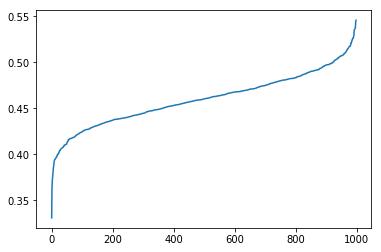

In [104]:
xxx = np.sort(inputdistance, 0)
plt.plot(xxx)
plt.show()

In [193]:
import math
distances = []
for i in index_1:
    distances.append(math.floor(inputdistance[i].item()* 40))

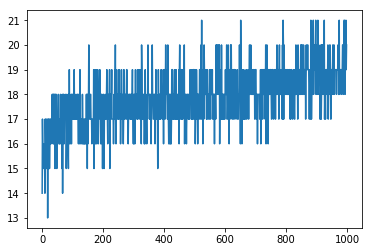

In [194]:
import matplotlib.pyplot as plt

plt.plot(distances)
plt.show()

In [46]:
F.cosine_similarity(torch.FloatTensor(f['train'][0]).unsqueeze(0), torch.FloatTensor(f['train'][6]).unsqueeze(0), dim=1, eps=1e-8)

tensor([0.3993])

In [ ]:
for x, y in zip(hash_distances[0][0:30], input_distances[0][0:30]):
    print (x, y)

In [ ]:
dataset_vector = model(torch.FloatTensor(f['train']))

In [ ]:
query_vector = model(torch.FloatTensor(f['test']))

In [ ]:
def binarization(vector):
    query_codes = []
    for v in vector:
        binary_code = []
        for e in v:
            if e < 0.5:
                binary_code.append(0)
            else:
                binary_code.append(1)
        query_codes.append(binary_code)
    return np.array(query_codes)
dataset_binary = binarization(dataset_vector.detach().numpy())
query_binary = binarization(query_vector.detach().numpy())

In [ ]:
len(dataset_binary)

In [ ]:
len(query_binary)

In [ ]:
import math
hash_table = {}
for idx, point in enumerate(dataset_binary):
    pos = 0
    key = 0
    for d in point:
        key += d * math.pow(2, pos)
        pos += 1
    if key in hash_table:
        hash_table[key].append(idx)
    else:
        hash_table[key] = [idx]

In [ ]:
f['neighbors'][:]

In [ ]:
def find_candidate_distance(vector, hash_table, candidate_num):
    candidate = []
    for point in query_binary:
        cand = []
        dis = 0
        while len(cand) < 100:
            pos = 0
            key = 0
            for d in point:
                key += d * math.pow(2, pos)
                pos += 1
            if key in hash_table:
                candidate.append(hash_table[key])
    return candidate
find_candidate_0_distance(query_binary, hash_table)

In [ ]:
class Node(object):
    def __init__(hash_code, data_index_set):
        self.hash_code = hash_code
        self.data_index_set = data_index_set
        self.children = []
        
    def isLeaf():
        return len(self.children) == 0
    
    def train(dataset):
        train_data = dataset[self.data_index_set]
        self.model = train(dataset)
        
    def partition():
        points = dataset[self.data_index_set]
        hash_table = {}
        codes = self.model(points)
        for idx, code in enumerate(codes):
            if code in hash_table:
                hash_table[code].append(self.data_index_set[idx])
            else:
                hash_table[code] = [self.data_index_set[idx]]
        for key,value in d.items():
            self.children.append(Node(key, value))
    
    def search(query, dataset):
        if self.isLeaf():
            return validate(dataset[self.data_index_set])
        else:
            children_idxes = select_children(query)
            result = []
            for idx in children_idxes:
                result += self.children[idx].search(query, dataset)
            return result
    
    
    

def index_construction(dataset):
    model = train(dataset)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

data = np.array(f['train'])

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(data[np.random.choice(data.shape[0], 100000, replace=False)])